In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from RS.core import *
from RS.model import *
import lovasz_loss as Lov

# Project name here

> Summary description here.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## How to use

Fill me in please! Don't forget code examples:

In [ ]:
from fastai.vision.all import *

In [ ]:
# torch.cuda.set_device(1)

In [ ]:
# df=pd.read_csv('./train.csv')
# imgs=get_files('/home/staff/xin/Downloads/tianchi/train/',extensions='.tif')
# df=pd.DataFrame({'path':imgs})

df=pd.read_csv('same.csv')

In [ ]:
df.head()

,path1,path2
0,/home/staff/xin/Downloads/tianchi/test/002664.tif,/home/staff/xin/Downloads/tianchi/train/015723.tif
1,/home/staff/xin/Downloads/tianchi/test/000901.tif,/home/staff/xin/Downloads/tianchi/train/011989.tif
2,/home/staff/xin/Downloads/tianchi/test/002469.tif,/home/staff/xin/Downloads/tianchi/train/014949.tif
3,/home/staff/xin/Downloads/tianchi/test/000774.tif,/home/staff/xin/Downloads/tianchi/train/014414.tif
4,/home/staff/xin/Downloads/tianchi/test/002890.tif,/home/staff/xin/Downloads/tianchi/train/011431.tif


In [ ]:
df=df.drop('path1',1)

In [ ]:
df.columns = ['path']

In [ ]:
df['valid']=0

In [ ]:
df2=df.copy()

In [ ]:
df2['valid']=1

In [ ]:
df=df.append(df2)

In [ ]:
df3=pd.DataFrame({'path':get_files('/home/staff/xin/Downloads/tianchi/teacher/',extensions='.tif')})

In [ ]:
df3['valid']=0

In [ ]:
df=df.append(df3)

In [ ]:
db = DataBlock(blocks=(TransformBlock(type_tfms=partial(RsImage.create)),
                       TransformBlock(type_tfms=partial(RsMask.create)),
                      ),
               get_x=ColReader('path'),
               get_y=ColReader('path'),
               splitter=ColSplitter('valid'),
               item_tfms=[aug,aug2]
              )
# db = DataBlock(blocks=(TransformBlock(type_tfms=partial(RsImage.create)),
#                        TransformBlock(type_tfms=partial(RsMask.create)),
#                       ),
#                get_x=ColReader('path'),
#                get_y=ColReader('path'),
#                splitter=RandomSplitter(valid_pct=0.2,seed=10),
#                item_tfms=[aug,aug2]
#               )

# db.summary(source=df)

In [ ]:

dls = db.dataloaders(source=df,bs=32, num_workers=8)


In [ ]:
from mmseg.models import build_segmentor
from mmcv.utils import Config

In [ ]:
class HRNET(nn.Module):
    def __init__(self,cfgfile):
        super().__init__()
        cfg = Config.fromfile(cfgfile)
        temp=build_segmentor(cfg.model)
        self.backbone =temp.backbone
        self.decode_head = temp.decode_head
    def forward(self, x):
#         x=F.upsample_bilinear(x,scale_factor=2)
        x = self.backbone(x)
        x = self.decode_head(x)
        return x

In [ ]:
# loss=OhemCrossEntropy()

In [ ]:
def mIOU( pred,label, num_classes=10,scale=4):
    pred =F.upsample_bilinear(pred,scale_factor=scale)  
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    
    iou_list = list()
    present_iou_list = list()
    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        if sem_class!=30:
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else: 
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
    return np.mean(present_iou_list)

In [ ]:
class newloss(nn.Module):
    def __init__(self,):
        super().__init__()
        self.loss = CrossEntropyLossFlat(axis=1)
    def forward(self, input, target):
        return self.loss(RsImage(input),RsImage(target.long()))

In [ ]:
class OhemCrossEntropy(nn.Module): 
    def __init__(self, ignore_label=-1, thres=0.7, 
        min_kept=100000, weight=None,scale=4): 
        super(OhemCrossEntropy, self).__init__() 
        self.thresh = thres
        self.min_kept = max(1, min_kept)
        self.ignore_label = ignore_label 
        self.weight=weight
        self.criterion = nn.CrossEntropyLoss(weight=weight, 
                                             ignore_index=ignore_label, 
                                             reduction='none') 
        self.scale=scale
#         self.love=Lovloss()
    
    def forward(self, score, target, **kwargs):
        target=RsImage(target.long())
        score =F.upsample_bilinear(score,scale_factor=self.scale)
        pred = F.softmax(score, dim=1)
        pixel_losses = self.criterion(score, target).contiguous().view(-1)
        mask = target.contiguous().view(-1) != self.ignore_label         
        
        tmp_target = target.clone() 
        tmp_target[tmp_target == self.ignore_label] = 0 
        pred = pred.gather(1, tmp_target.unsqueeze(1)) 
        pred, ind = pred.contiguous().view(-1,)[mask].contiguous().sort()
        min_value = pred[min(self.min_kept, pred.numel() - 1)] 
        threshold = max(min_value, self.thresh) 
        
        pixel_losses = pixel_losses[mask][ind]
        pixel_losses = pixel_losses[pred < threshold] 
        iouloss=Lov.lovasz_softmax(score,target,class_weight=None)
        return pixel_losses.mean()+iouloss/10

In [ ]:
class Lovloss(nn.Module): 
    def __init__(self, ignore_label=-1, thres=0.7, 
        min_kept=100000, weight=None): 
        super(Lovloss, self).__init__() 
        self.weight=weight
    
    def forward(self, score, target, **kwargs):
        target=RsImage(target.long())
        score =F.upsample_bilinear(score,scale_factor=4)
        pred = F.softmax(score, dim=1)
        return Lov.lovasz_softmax(score,target,class_weight=self.weight)

In [ ]:
weight=torch.FloatTensor([2,1,4,4,2,2,2,4,2,4]).cuda()

In [ ]:
loss=OhemCrossEntropy(weight=weight,scale=4)

In [ ]:
loss=Lovloss()

In [ ]:

model=HRNET(cfgfile='./fcn_hr18.py')
apply_init(model)

In [ ]:
learn = Learner(dls,model,metrics=mIOU,loss_func=loss).to_fp16()

In [ ]:
learn.load('hrnetdis')

SuggestedLRs(lr_min=0.33113112449646, lr_steep=7.585775847473997e-07)

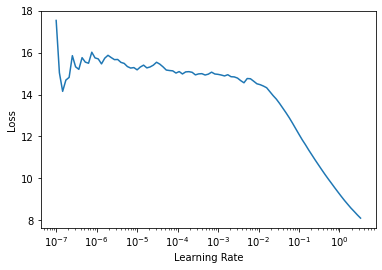

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(50, 1e-4,cbs=[CSVLogger(fname='hrnetdisiou.csv',append=False),SaveModelCallback(monitor='mIOU',fname='hrnetdisiou')])

epoch,train_loss,valid_loss,mIOU,time
0,2.838255,2.694573,0.501026,01:18
1,2.786370,2.624660,0.499610,01:18
2,2.771975,2.706831,0.502593,01:18
3,2.736063,2.680830,0.500134,01:18
4,2.698779,2.569799,0.502402,01:18
5,2.643351,2.523158,0.500445,01:18
6,2.586297,2.506221,0.498768,01:18
7,2.528554,2.489947,0.499351,01:18
8,2.447443,2.418167,0.495543,01:18
9,2.373564,2.308167,0.494401,01:18


Better model found at epoch 0 with mIOU value: 0.5010259897400318.
Better model found at epoch 2 with mIOU value: 0.5025931797682388.


In [ ]:
learn = Learner(dls,model,metrics=mIOU,loss_func=Lovloss()).to_fp16()

In [ ]:
learn.load('hrnetdis')

In [ ]:
learn.lr_find()

In [ ]:
learn.load('resunet')

In [ ]:
stats=torch.load('./models/hrnet.pth')

In [ ]:
model.load_state_dict(stats)

<All keys matched successfully>

In [ ]:
imgs=get_files('/home/staff/xin/Downloads/tianchi/test/')

In [ ]:
model=model.cuda().eval()

In [ ]:
import skimage.io as skio
import tqdm

In [ ]:
for img in tqdm.tqdm(imgs):
    temp=RsImage.create(img)
    temp=val_pipe(image=temp.numpy())['image']
    with torch.no_grad():
        result=model(temp.unsqueeze(0).cuda())
    result =F.upsample_nearest(result,scale_factor=4)
    result=result.argmax(axis=1)
    result=result[0]+1
    result=result.cpu().numpy().astype('uint8')
    newname='/home/staff/xin/Downloads/tianchi/resultV0/'+img.name.replace('tif','png')
    skio.imsave(newname,result)

100%|██████████| 3000/3000 [02:44<00:00, 18.25it/s]


In [ ]:
means=[]
for img in tqdm.tqdm(imgs):
    temp=RsImage.create(img)
    temp=val_pipe(image=temp.numpy())['image']
    with torch.no_grad():
        result=model(temp.unsqueeze(0).cuda())
    result =F.upsample_bilinear(result,scale_factor=4)
    result=F.softmax(result)
    mean=result.max(dim=1)[0].mean()
    if mean>0.685:
        result=result.argmax(axis=1)
        result=result[0]+1
        result=result.cpu().numpy().astype('uint8')
        newname='/home/staff/xin/Downloads/tianchi/teacher/'+img.name.replace('tif','png')
        skio.imsave(newname,result)
        shutil.copyfile(str(img),str(img).replace('test','teacher'))

100%|██████████| 3000/3000 [01:35<00:00, 31.48it/s]


In [ ]:
xx=[]
for mean in means:
    xx.append(mean.cpu().item())

In [ ]:
xx=np.asarray(xx)

In [ ]:
np.count_nonzero(xx>0.685)

1400

tensor(0.6834, device='cuda:0')

In [ ]:
result=result.argmax(axis=1)
result=result[0]+1

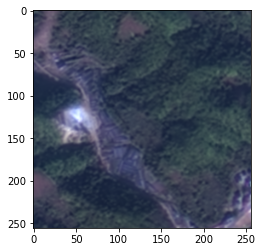

In [ ]:
RsImage.create(img).show()

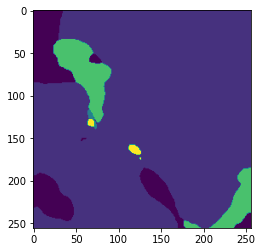

In [ ]:
plt.imshow(result.cpu())

In [ ]:
xx=skio.imread('/home/staff/xin/Downloads/tianchi/train/010000.png')

In [ ]:
import geopandas as gpd

In [ ]:
xx=gpd.read_file('/home/staff/xin/stationbasins.geojson')

In [ ]:
xx.to_file('/home/staff/xin/tan/chun')